Copyright (c) 2024, Daniel García Algora, David García Guillén

# Data gathering

For this project it was decided to collect data from plants, both from a lemon tree and a tomato plant of the Kybele association.
tomato plant of the Kybele association, was outdoors in order to collect the data, the hardware sensors were connected to an ESP32 which connected via WIFI to the eudoroam network. It had a bad connection so there should be missing values on the recollected data. The recollection of data was made in ranges of 30-second intervals. The information was stored in google sheets. Never the less, due to the unstable wifi connection, the infrastructure created for the exterior plants, wasn't fully prepared and overheat and some sensors, even protected for water, didn't worked as expected, so the data was not as good as it should has been, plus the malfunction of some newly-purchased sensors like the SD card. The solution to this was to use an 8 month avocado plant indoors and meassure  the values on a more controlled environment.

The sensors used on each plant are the same.

* **Moisture sensor** to meassure the level of water on the ground.
  * The moisture sensor started working erratically because it was damaged, and it can be seen on the charts. For this reason, a rolling mean for training and prediction.
* Two **DHT sensors** for humidity and temperature. One for the top of the tree and the other for the ground.
* **Sunlight sensors** to gather the amount of sun on the top and bottom of the plant.
  * Bad decision because the bought sensors gave relative sunlight data.

## Lemon tree deployment

![Lemon tree](../imgs/limonero.png)

## Tomato plant

![Tomate plant](../imgs/tomato_plant_0.png)
![Tomate plant](../imgs/tomato_plant_1.png)

## Avocado plant

![Avocado plant](../imgs/avocado_plant_0.png)
![Avocado plant](../imgs/avocado_plant_1.png)

# EDA

Los datos recogidos en este dataset tienen las siguientes filas: ``timestamp``, ``light_air``, ``light_ground``, ``moisture_ground``, ``dht_air_humidity``, ``dht_air_temperature``, ``dht_ground_humidity``, ``dht_ground_temperature``.


La variable a predecir es ``moisture_ground``.

In [1]:
from ydata_profiling import ProfileReport
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

c:\Users\Bl1tty\Documents\Uni\temporales\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/HUERTO-ESP32 - huerto_casa.csv")

In [3]:
df.isnull().sum()

timestamp                 0
light_air                 0
light_ground              0
moisture_ground           0
dht_air_humidity          0
dht_air_temperature       0
dht_ground_humidity       0
dht_ground_temperature    0
dtype: int64

## Train test split

* **Test** dataset is last 1000 rows allocated for validation purposes.
* **Training** dataset is first 9000 rows.

In [4]:
test_data = df.tail(1000)
train_data = df.head(9000)

In [5]:
train_data.head()

,timestamp,light_air,light_ground,moisture_ground,dht_air_humidity,dht_air_temperature,dht_ground_humidity,dht_ground_temperature
0,1697063380,2311,1999,944,40,24.4,40,24.3
1,1697063416,2325,2006,929,40,24.3,40,24.3
2,1697063450,2320,2003,952,40,24.3,40,24.3
3,1697063484,2329,1999,950,40,24.3,40,24.2
4,1697063518,2307,1983,961,40,24.3,40,24.2


## Analysis

### Automated analisys

Data is automated using `ydata_profiling` library which helps reducing repetitive code.

On the report, it can be seen how the variables “dht_ground_temperature”, “dht_air_temperature” and “moisture_grouind” can approximate normal distributions, with the presence of some outliers.

It is also possible to observe how the variables related to air and soil humidity behave in a cyclical manner, with a
The scale on which they are plotted shows a slight difference in the central hours of the day.

In [6]:
report = ProfileReport(train_data, tsmode=True, title="Time series gardeen")
# report.to_file('time_series_gardeen_report.html')

## Time series column analysis

Data gathered for each column:

- ``p-value`` : indicates the order of the difference (lag) between the present and past data. if p-value is <= 0.05 then null hypothesis is rejected, and the timeseries is stationary.
- ``ADF Statistic`` : Value of Augmented Dickey Fuller tests the null hypothesis that a unit root is present in a time series sample.
- ``Critical values`` : Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
- ``Seasonality`` : Presence of variations that occur at specific regular intervals.
- ``kpss`` : Analize if a time series is stationary around a deterministic trend.

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
def analize_column(column: pd.Series, is_plot: bool = True):
    """
    Analyze ``p-value``, ``ADF statistics``, ``Critical values`` and ``Seasonality`` for a given column

    Parameters
    ----------
    - col_name : str

        Name of the column

    - is_plot : bool = True

    Returns
    -------

    - has_trend, is_stationary, is_seasonal : Tuple[bool, bool, bool]
    """

    adf_result = adfuller(column)
    kpss_result = kpss(column)

    column_name = column.name
    decomposition = seasonal_decompose(column, model='additive', period=1)

    is_stationary = adf_result[1] < 0.05  # ADF p-value less than 0.05 indicates stationarity
    is_seasonal = decomposition.seasonal is not None  # If seasonal component exists
    has_trend = kpss_result[1] < 0.05

    print(f"Column: {column_name}")
    print("==== ADF statistic ====")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print(f"Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t* {key}: {value}")
    print()
    print("==== KPSS statistic ====")
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value}')

    if is_stationary:
        print(f'{column_name} is stationary according to ADF test.')
    
    if is_seasonal:
        print(f'{column_name} is seasonal according to ADF test.')

    if has_trend:
        print(f'{column_name} contains trend according to KPSS test.')

    if is_plot:
        plot_acf(column, lags=30)
        plt.title(f'ACF for {column_name}')
        plt.show()

        decomposition.plot()
        plt.show()

    return has_trend, is_stationary, is_seasonal

In [10]:
stats = {}

### Individual columns

#### Light air

Column: light_air
==== ADF statistic ====
ADF Statistic: -3.1930164640947303
p-value: 0.020392489093998423
Critical Values:
	* 1%: -3.4310794717255386
	* 5%: -2.8618623790201543
	* 10%: -2.566941597330181

==== KPSS statistic ====
KPSS Statistic: 0.5077425928153974
p-value: 0.039922839455991586
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
light_air is stationary according to ADF test.
light_air is seasonal according to ADF test.
light_air contains trend according to KPSS test.


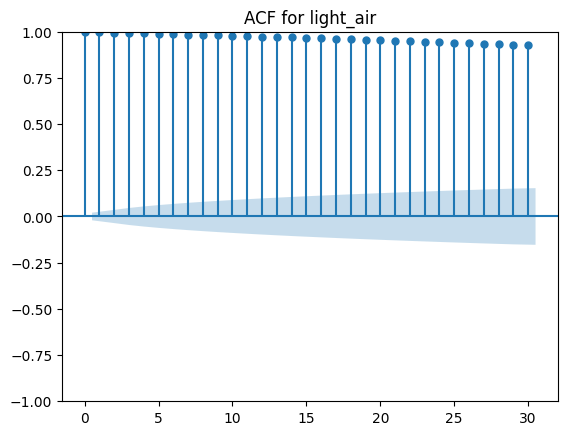

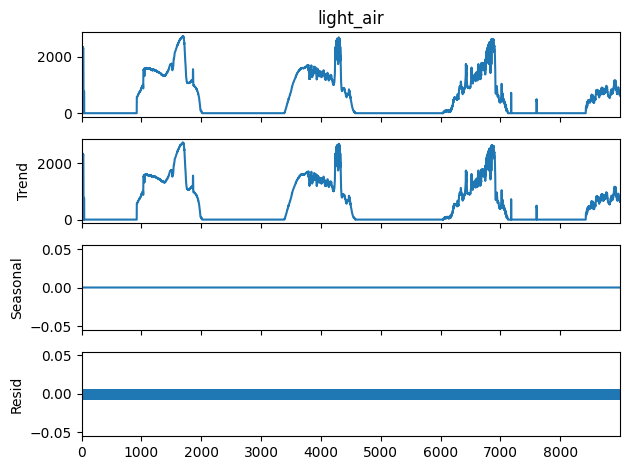

In [14]:
light_air = analize_column(train_data["light_air"])
stats["light_air"] = light_air

#### Light ground 

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(column)


Column: light_ground
==== ADF statistic ====
ADF Statistic: -2.0407991058996164
p-value: 0.2689754404916045
Critical Values:
	* 1%: -3.4310794717255386
	* 5%: -2.8618623790201543
	* 10%: -2.566941597330181

==== KPSS statistic ====
KPSS Statistic: 0.2858718374205819
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
light_ground is seasonal according to ADF test.


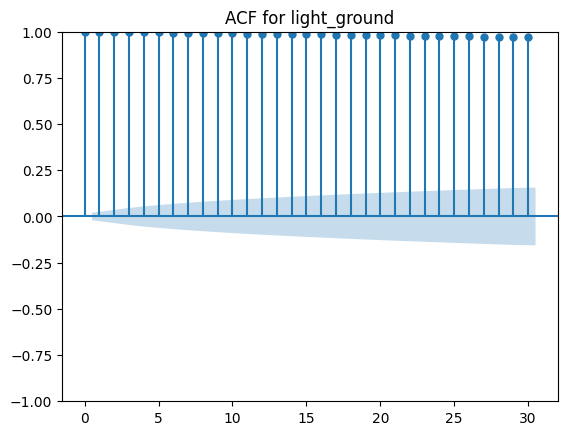

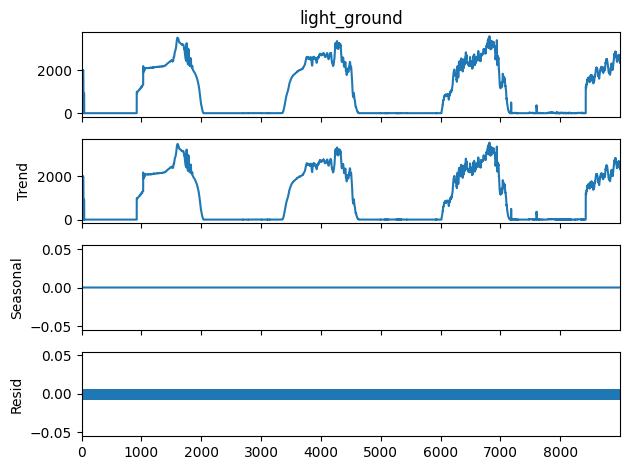

In [15]:
light_ground = analize_column(train_data["light_ground"])
stats["light_ground"] = light_ground

#### Moisture ground

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(column)


Column: moisture_ground
==== ADF statistic ====
ADF Statistic: -5.918765349666914
p-value: 2.535678425825205e-07
Critical Values:
	* 1%: -3.431079878822629
	* 5%: -2.8618625589084705
	* 10%: -2.566941693085751

==== KPSS statistic ====
KPSS Statistic: 1.233194895599859
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
moisture_ground is stationary according to ADF test.
moisture_ground is seasonal according to ADF test.
moisture_ground contains trend according to KPSS test.


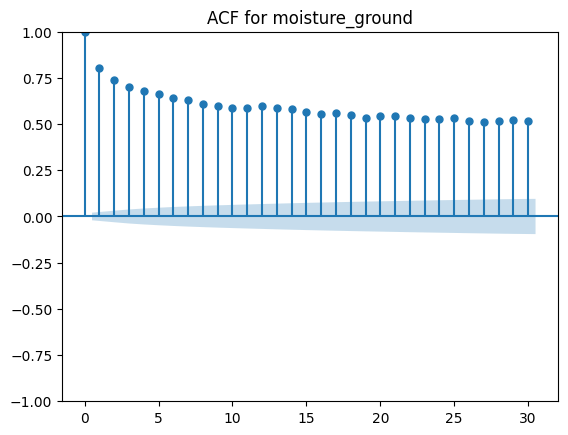

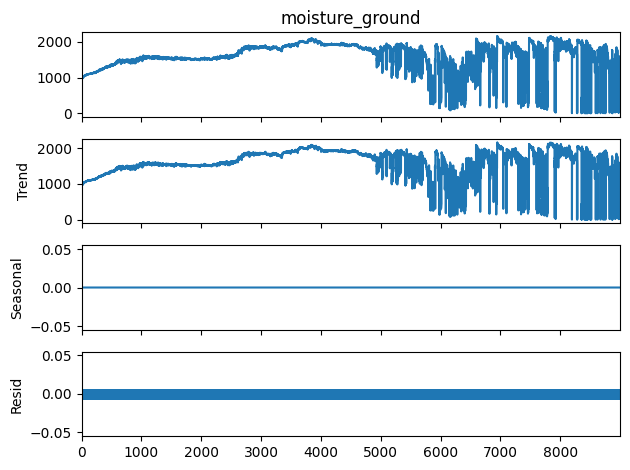

In [16]:
moisture_ground = analize_column(train_data["moisture_ground"])
stats["moisture_ground"] = moisture_ground

#### Dht air humidity

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(column)


Column: dht_air_humidity
==== ADF statistic ====
ADF Statistic: -0.42670482739253485
p-value: 0.9055436407983337
Critical Values:
	* 1%: -3.431078902551946
	* 5%: -2.8618621275133314
	* 10%: -2.56694146345168

==== KPSS statistic ====
KPSS Statistic: 11.246840382579773
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
dht_air_humidity is seasonal according to ADF test.
dht_air_humidity contains trend according to KPSS test.


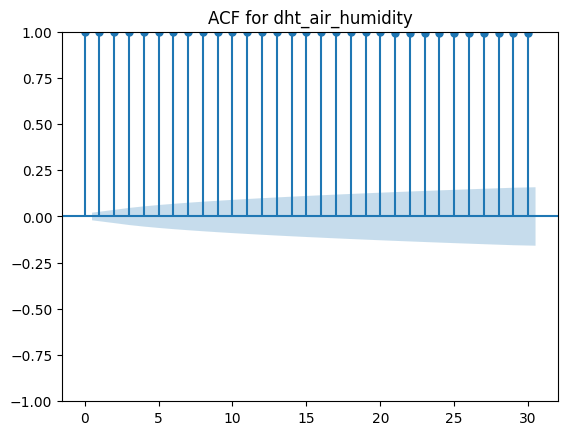

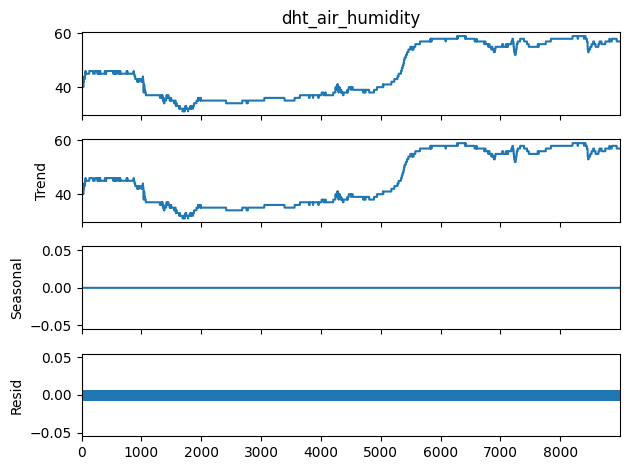

In [17]:
dht_air_humidity = analize_column(train_data["dht_air_humidity"])
stats["dht_air_humidity"] = dht_air_humidity

#### Dht air temperature

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(column)


Column: dht_air_temperature
==== ADF statistic ====
ADF Statistic: -2.750421808631767
p-value: 0.06571204902161162
Critical Values:
	* 1%: -3.4310794717255386
	* 5%: -2.8618623790201543
	* 10%: -2.566941597330181

==== KPSS statistic ====
KPSS Statistic: 6.715633513429611
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
dht_air_temperature is seasonal according to ADF test.
dht_air_temperature contains trend according to KPSS test.


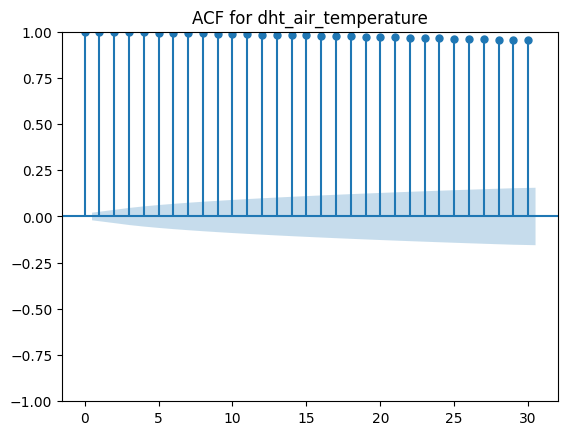

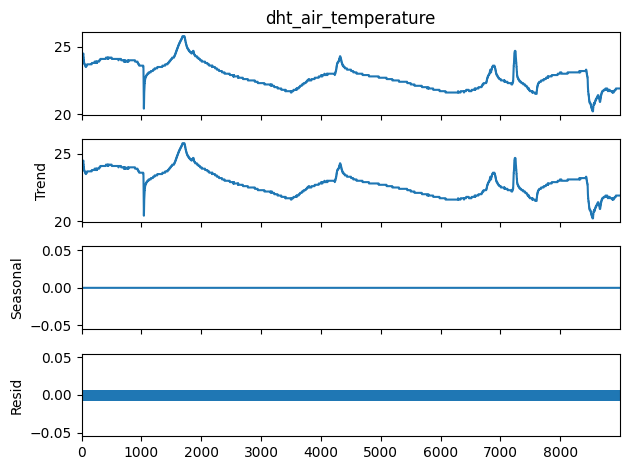

In [18]:
dht_air_temperature = analize_column(train_data["dht_air_temperature"])
stats["dht_air_temperature"] = dht_air_temperature

#### Dht ground humidity

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(column)


Column: dht_ground_humidity
==== ADF statistic ====
ADF Statistic: -0.7192878489538947
p-value: 0.8416900958207978
Critical Values:
	* 1%: -3.4310790650823195
	* 5%: -2.8618621993323705
	* 10%: -2.566941501681359

==== KPSS statistic ====
KPSS Statistic: 11.661964815083811
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
dht_ground_humidity is seasonal according to ADF test.
dht_ground_humidity contains trend according to KPSS test.


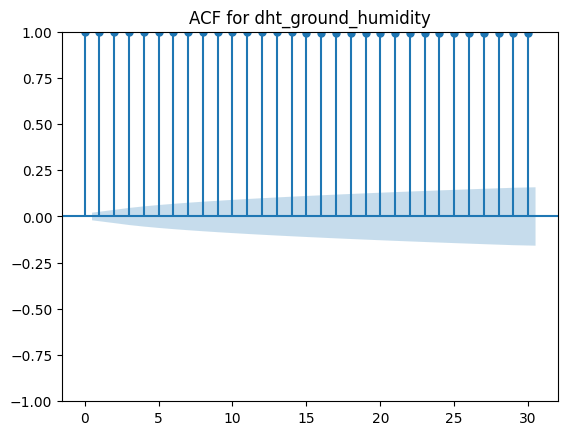

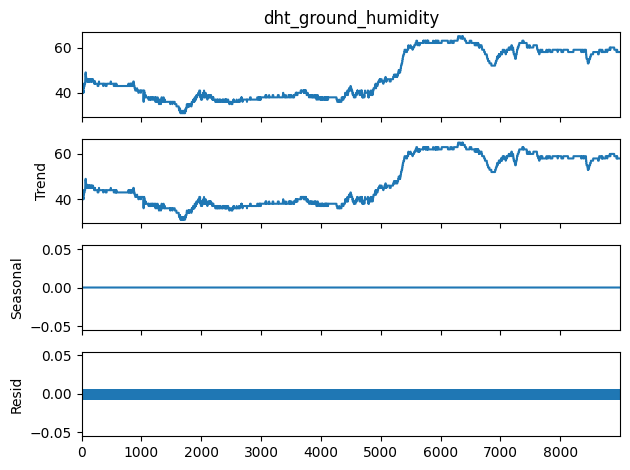

In [19]:
dht_ground_humidity = analize_column(train_data["dht_ground_humidity"])
stats["dht_ground_humidity"] = dht_ground_humidity

#### Dht ground temperature

C:\Users\Bl1tty\AppData\Local\Temp\ipykernel_4104\3256054132.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(column)


Column: dht_ground_temperature
==== ADF statistic ====
ADF Statistic: -2.7899234693718578
p-value: 0.05972760719558708
Critical Values:
	* 1%: -3.431077766865211
	* 5%: -2.861861625675143
	* 10%: -2.5669411963204065

==== KPSS statistic ====
KPSS Statistic: 4.08785084626922
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
dht_ground_temperature is seasonal according to ADF test.
dht_ground_temperature contains trend according to KPSS test.


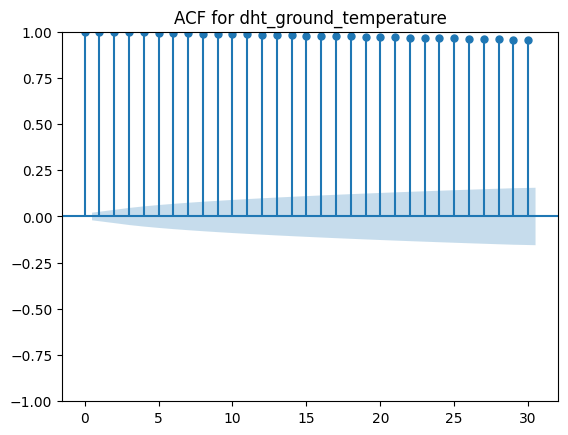

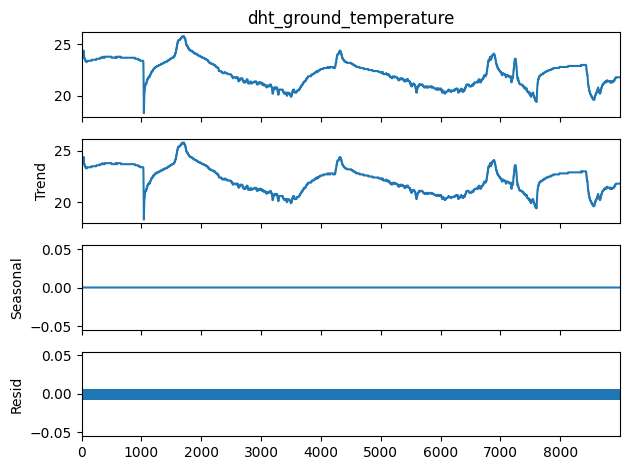

In [20]:
dht_ground_temperature = analize_column(train_data["dht_ground_temperature"])
stats["dht_ground_temperature"] = dht_ground_temperature

### All variable statistics

Filter by stationary and seasonality variables, in order to apply a detrending if necessary.

In [21]:
for column, value in stats.items():
    print(f"* {column}:\n\t* has_trend : {value[0]}\n\t* is_stationary : {value[1]}\n\t* is_seasonal: {value[2]}")

* light_air:
	* has_trend : True
	* is_stationary : True
	* is_seasonal: True
* light_ground:
	* has_trend : False
	* is_stationary : False
	* is_seasonal: True
* moisture_ground:
	* has_trend : True
	* is_stationary : True
	* is_seasonal: True
* dht_air_humidity:
	* has_trend : True
	* is_stationary : False
	* is_seasonal: True
* dht_air_temperature:
	* has_trend : True
	* is_stationary : False
	* is_seasonal: True
* dht_ground_humidity:
	* has_trend : True
	* is_stationary : False
	* is_seasonal: True
* dht_ground_temperature:
	* has_trend : True
	* is_stationary : False
	* is_seasonal: True


### Descriptive statistics with rolling window

This type of analysis uses the past and present data to compute descriptive statistics. Not good for anomaly detection.

#### Rolling descriptions

Is the mean of a timeseries over the time.

In [22]:
WINDOW_LEN = 30  # 30s is the periodicity of the timeseries

In [23]:
def plot_rolling_description(col: pd.Series):
    fig, axs = plt.subplots(3, figsize=(15, 10))

    ## rolling mean with std deviation
    col.plot(ax=axs[0], label="raw data")
    yt = col.rolling(WINDOW_LEN).mean()
    rolling_std = col.rolling(WINDOW_LEN).std()
    axs[0].fill_between(train_data.index, yt + (2 * rolling_std), yt - (2 * rolling_std), alpha=0.2, color=u'#ff7f0e', label="standard error")
    yt.plot(ax=axs[0], label="rolling mean")
    axs[0].set_title("rolling mean with standard deviation")
    axs[0].legend()

    ## Rolling quantiles
    col.plot(ax=axs[1], label="raw data")
    q1 = col.rolling(WINDOW_LEN).quantile(.1)
    median = col.rolling(WINDOW_LEN).quantile(.5)
    q3 = col.rolling(WINDOW_LEN).quantile(.9)
    median.plot(ax=axs[1], label="rolling mean")
    rolling_std = col.rolling(WINDOW_LEN).std()
    axs[1].fill_between(col.index, q1, q3, alpha=0.2, color=u'#ff7f0e')
    axs[1].set(xlabel="Time")
    axs[1].set_title("Rolling quantiles")
    axs[1].legend()

    ## Exponential weighted mean
    col.plot(ax=axs[2], label="raw data")
    col.ewm(span=5).mean().plot(ax=axs[2], label="rolling mean")
    axs[2].set(xlabel="Time")
    axs[2].set_title("Exponential weighted mean")
    axs[2].legend()

    fig.suptitle(f'Rolling description of {col.name}', fontsize=16)
    plt.tight_layout()
    plt.show()

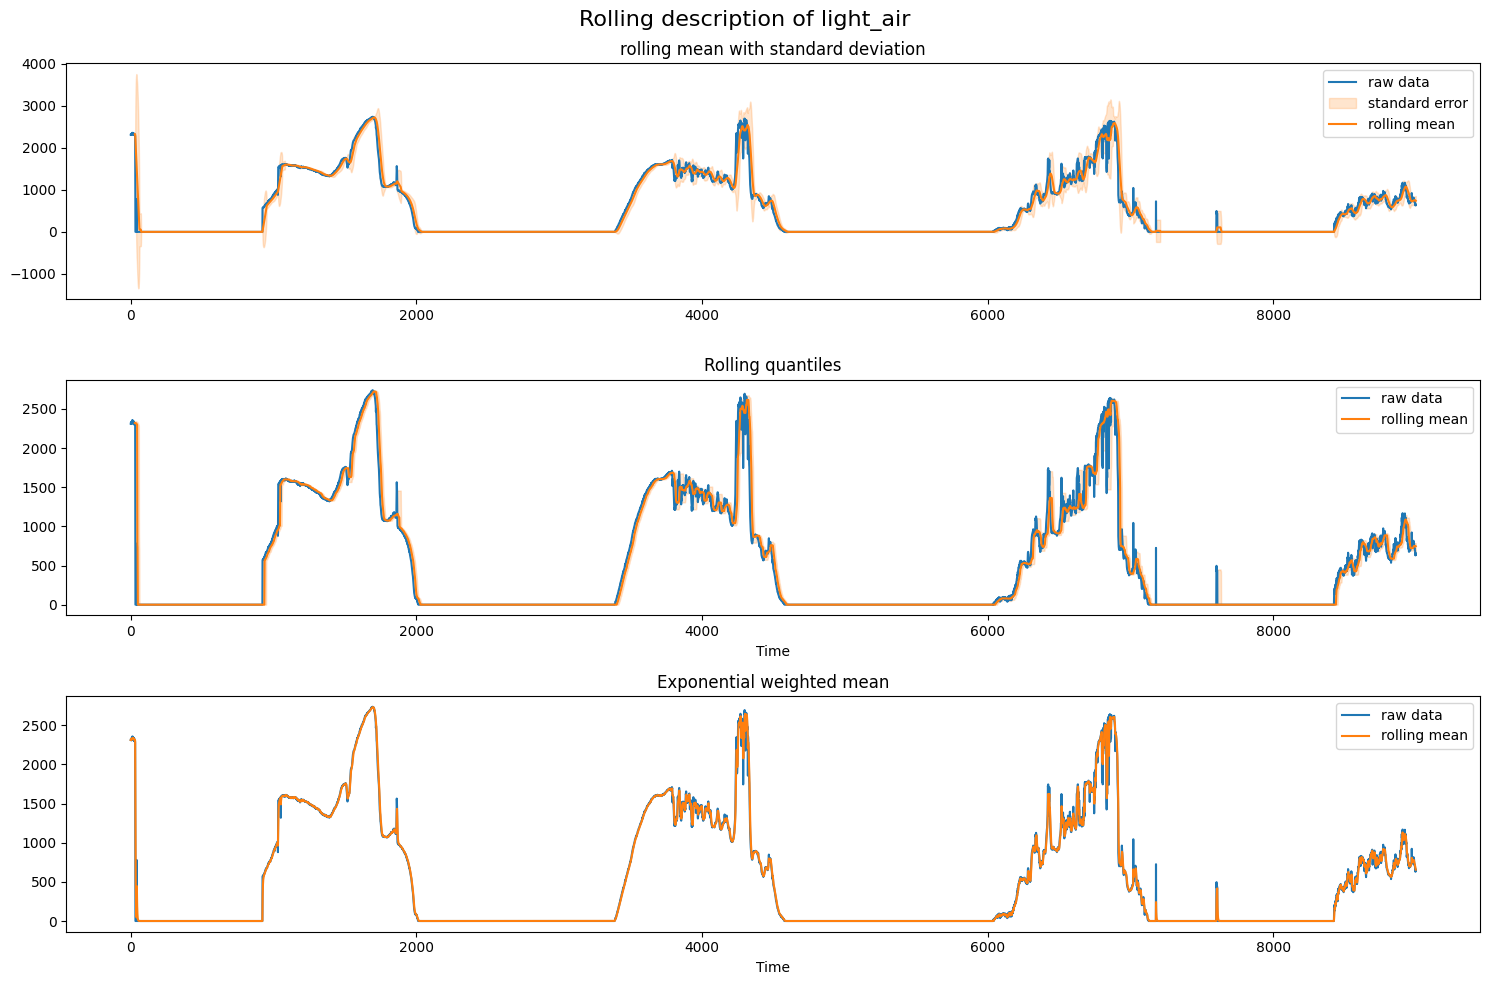

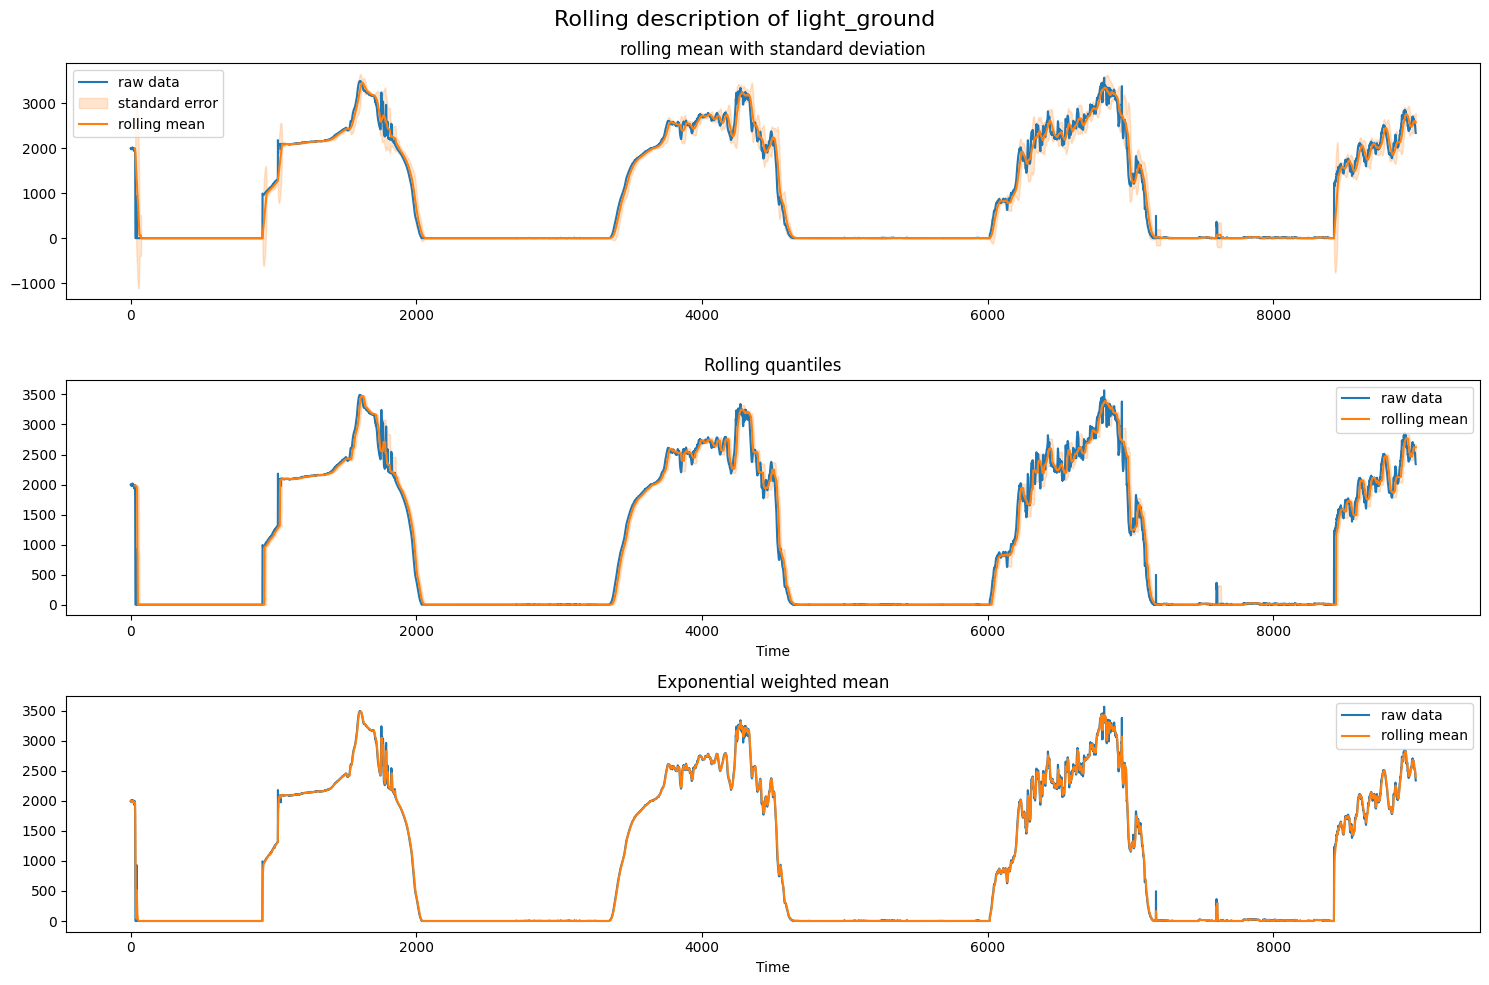

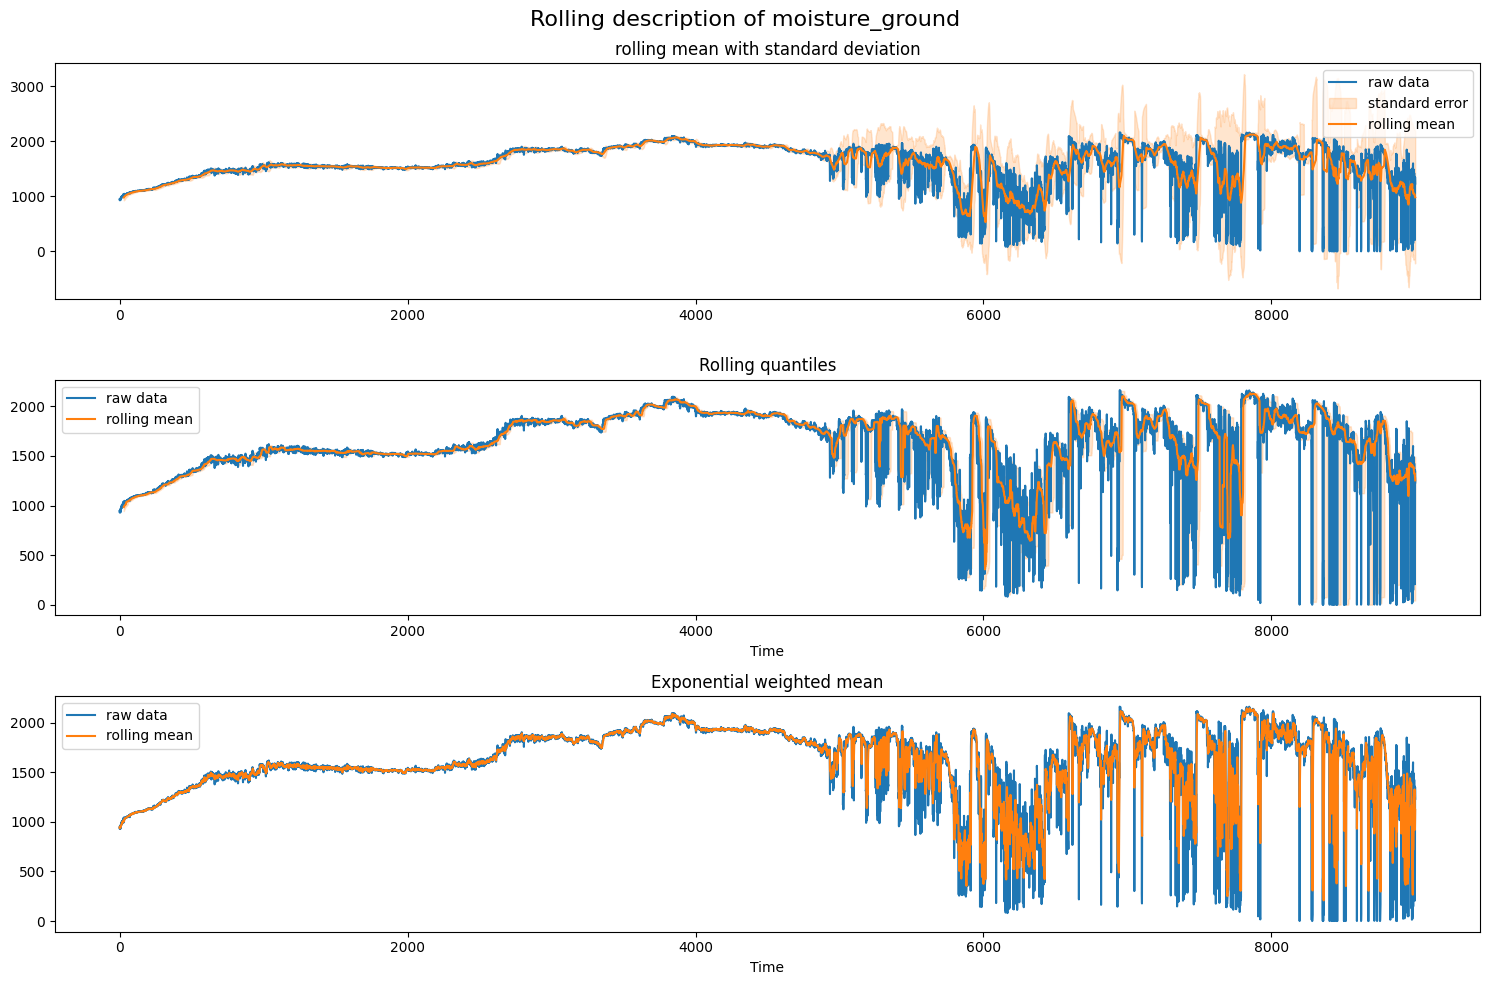

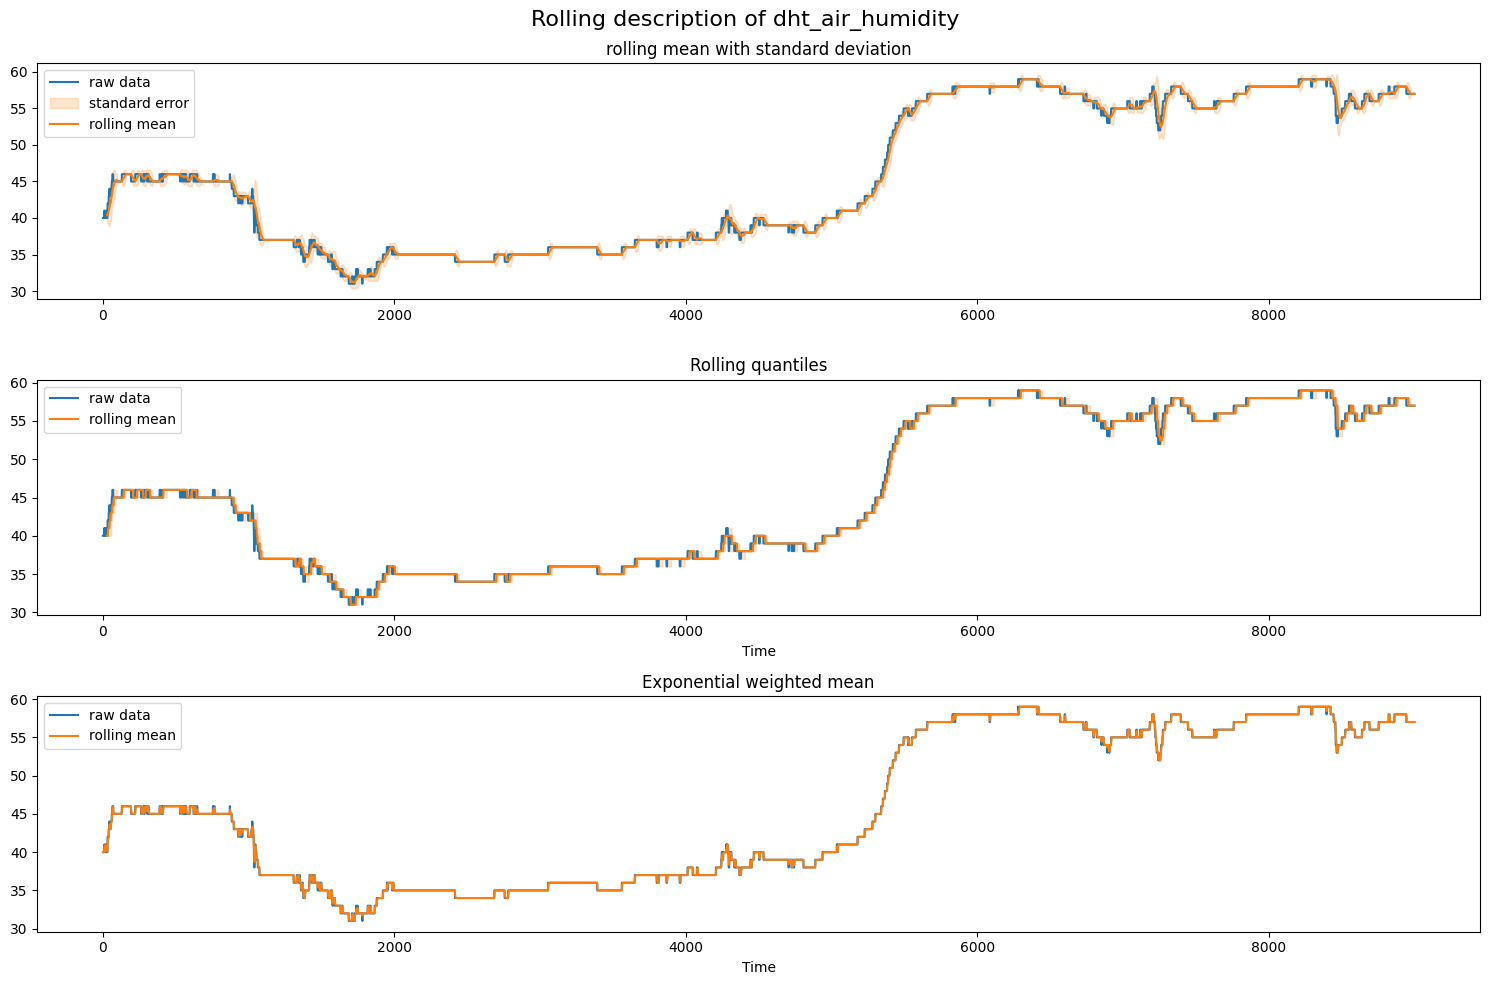

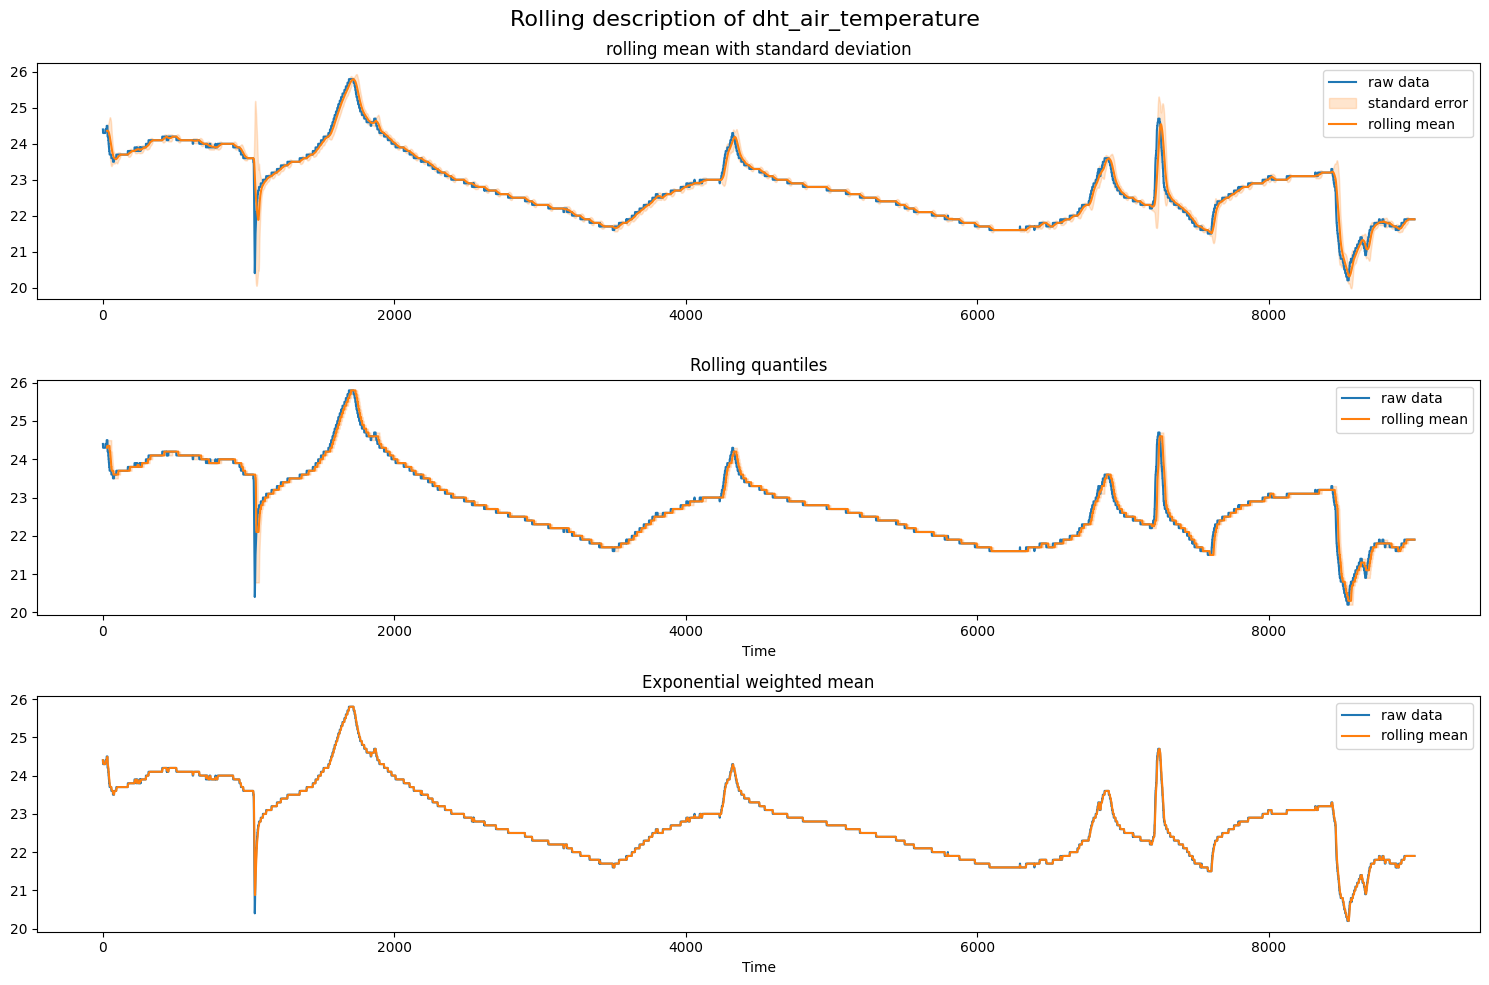

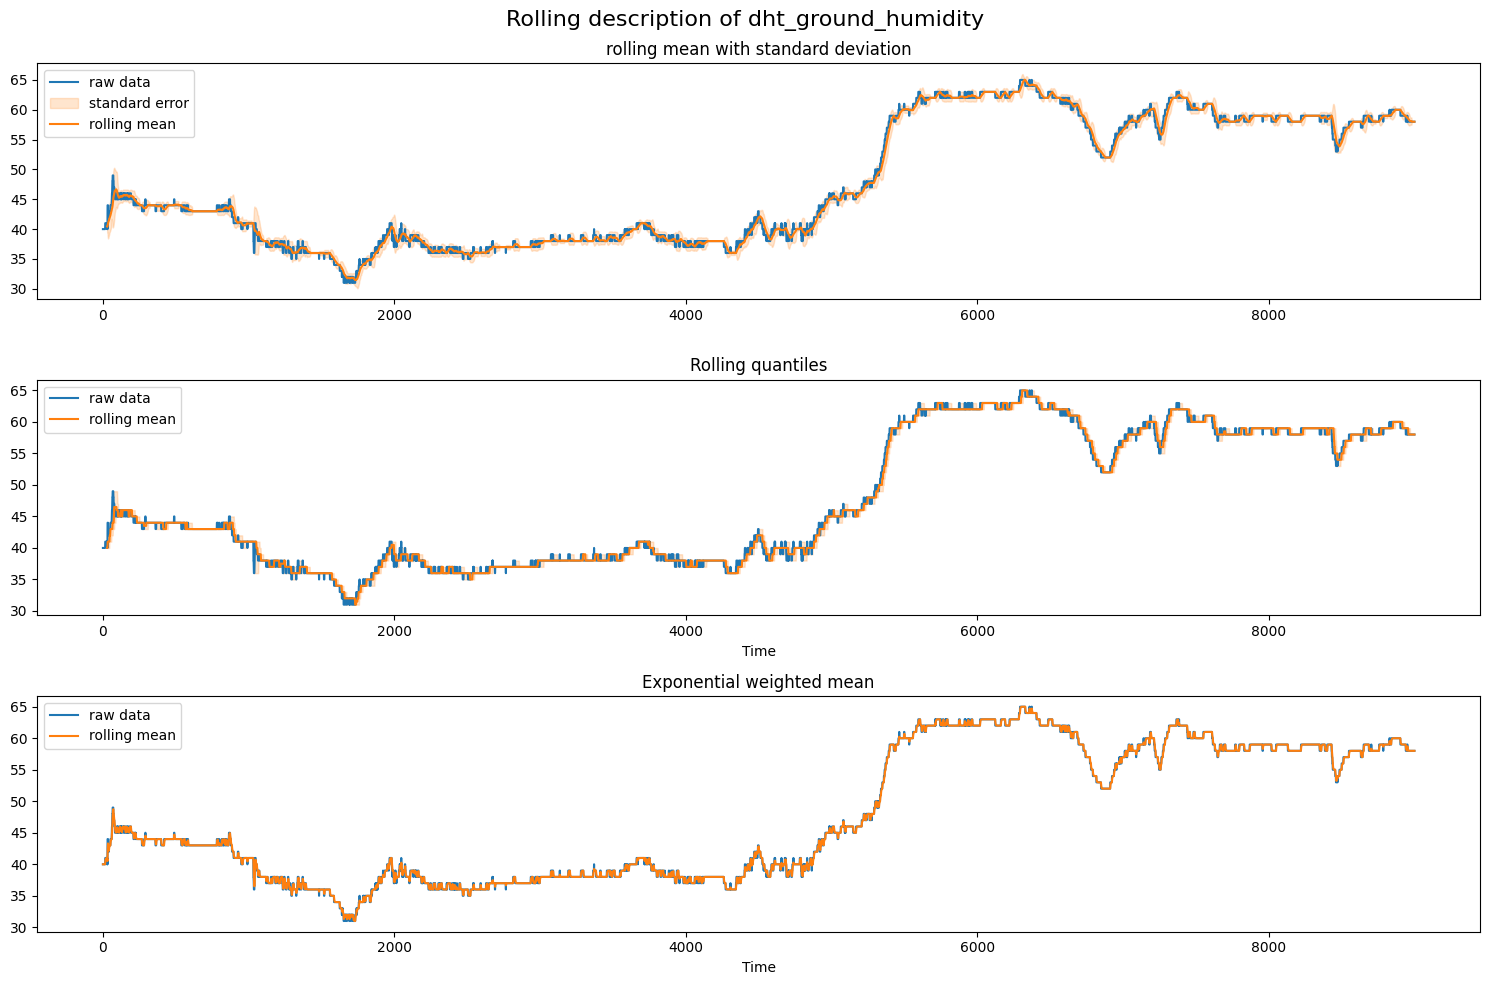

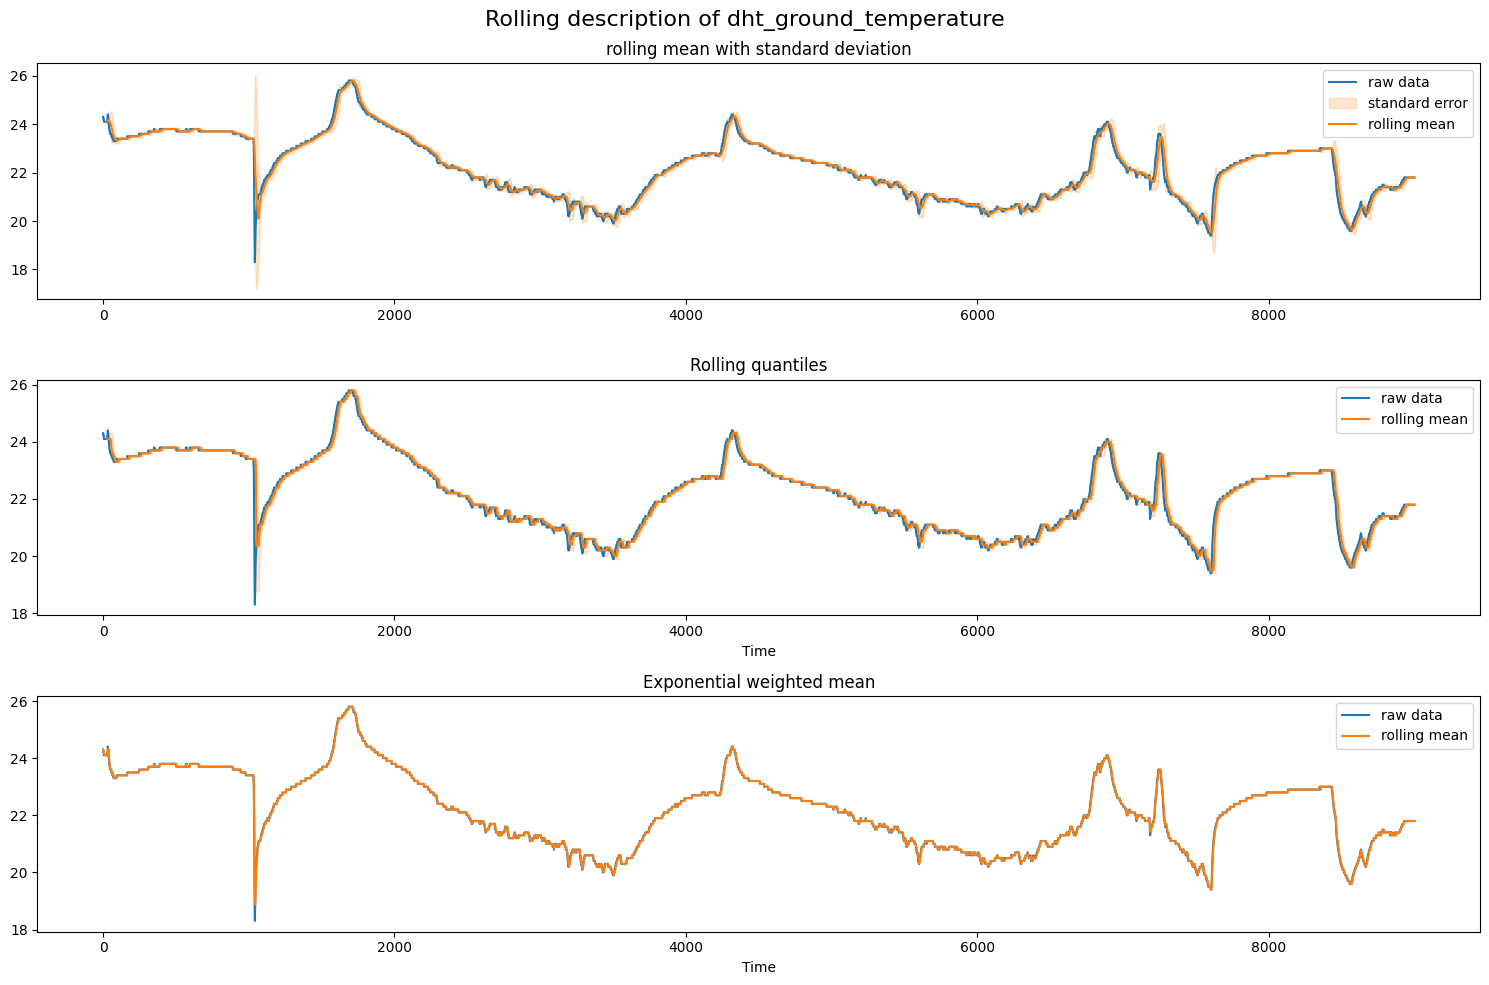

In [84]:
for key in stats.keys():
    plot_rolling_description(train_data[key])

#### Trends & seasonality

* Trend is the overall direction and movement of a time series over an extended period.
* Seasonality refers to recurring patterns or fluctuations that occur within a time series at fixed intervals, typically less than a year

In [24]:
def plot_trend_seasonality(col: pd.Series):
    sp = 30  # seasonal periodicity, or periods per year

    decomposition = seasonal_decompose(col, model="additive", period=sp)

    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
    col.plot(ax=ax, label="original")
    decomposition.seasonal.plot(ax=ax, label="seasonal")
    decomposition.trend.plot(ax=ax, label="trend")
    decomposition.resid.plot(ax=ax, label="residual")
    ax.set(xlabel="Time", ylabel=col.name)
    plt.legend()

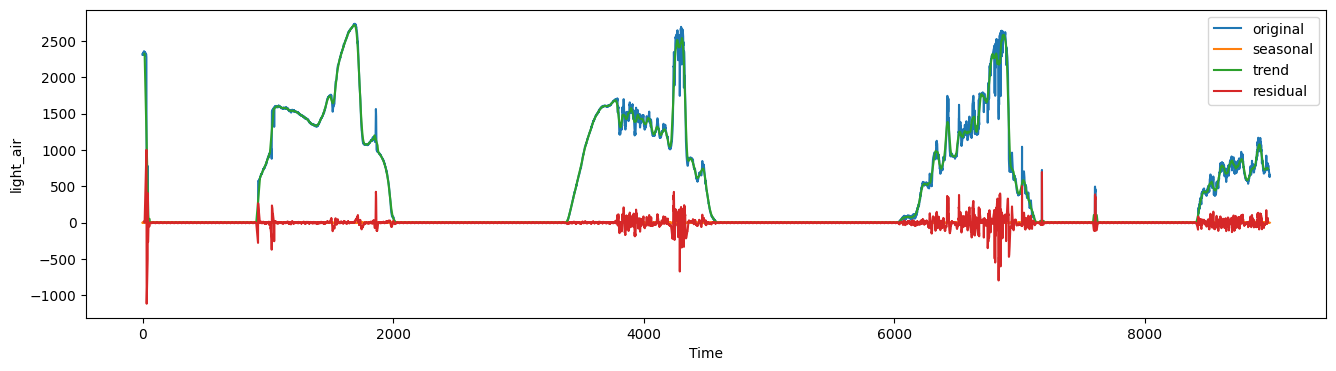

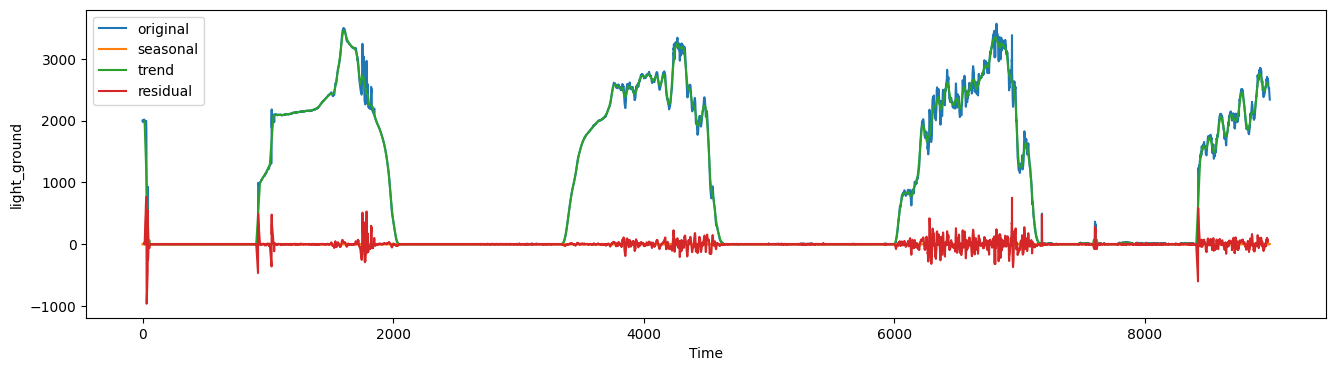

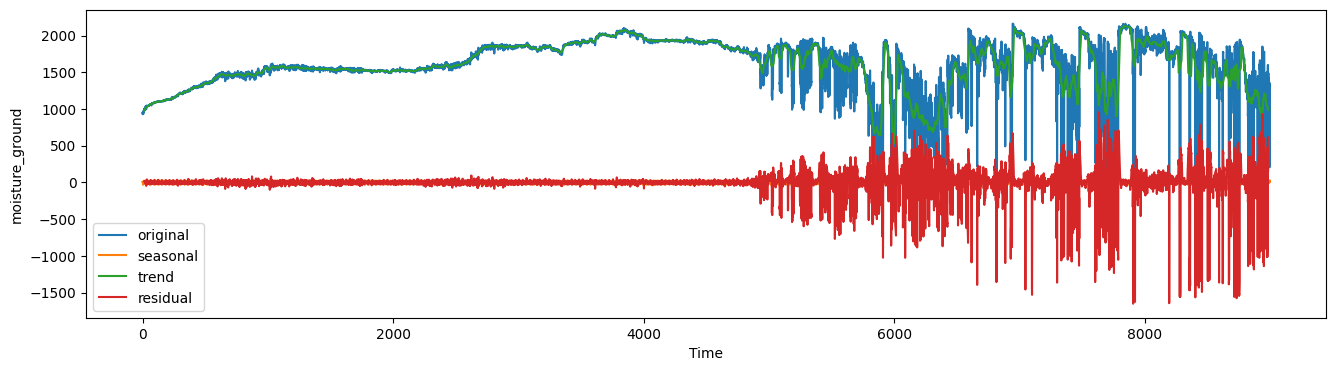

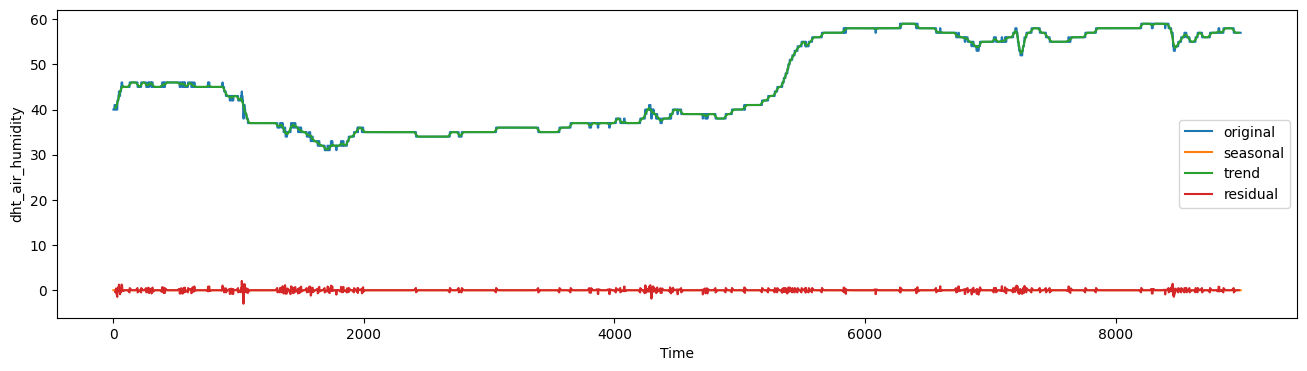

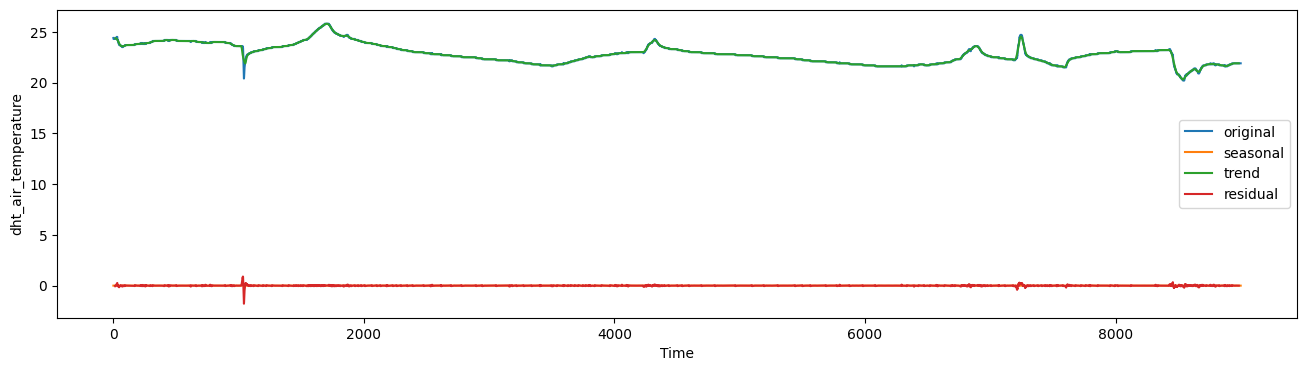

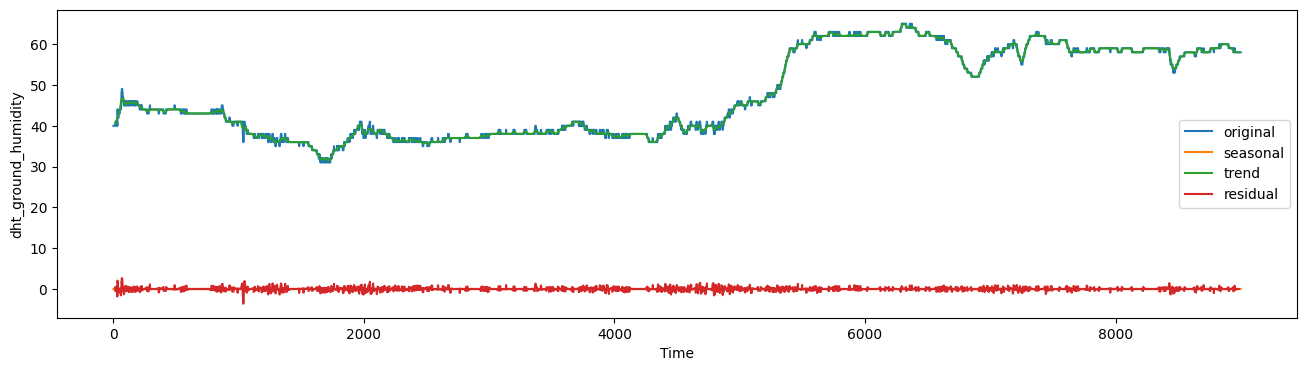

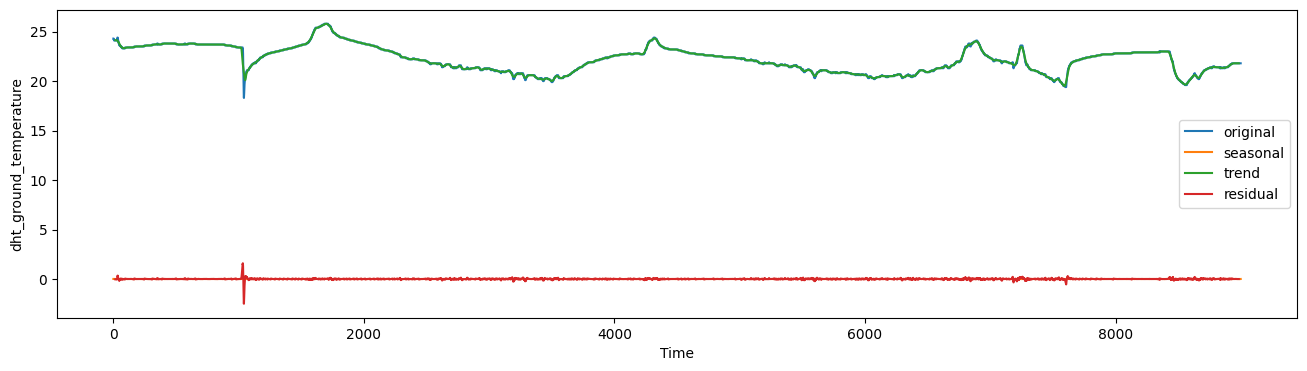

In [25]:
for key in stats.keys():
    plot_trend_seasonality(train_data[key])

## Timestamp data

Verify timestamp has a timelapse with next of around 30s. If diff >= 60s then data has been lost.

In [26]:
timestamps = train_data['timestamp']

In [27]:
delay = 30      # s
threshold = 30  # s

t = int(timestamps[0])
c = 0
# print(len(timestamps[1:]))
for i, timestamp in enumerate(timestamps[1:]):
    diff = int(timestamp) - t
    t = int(timestamp)

    # missing data from sensors
    if diff >= 60:
        c += diff // 30

print(f"Total missing values: {c}")

Total missing values: 483


## Generate datasets

In order to do the preprocessing and training/testing the model, train and test data are exported to a csv file.

In [22]:
# train_data.to_csv('../data/split/train_data.csv', index=False)
# test_data.to_csv('../data/split/test_data.csv', index=False)